# Load Model

In [2]:
from inference import load_model, predict_emotion, load_label_encoder, preprocess_audio, compute_gradcam
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from gtts import gTTS
from io import BytesIO
from IPython.display import Audio, display

# Load model and label encoder
model = load_model("best_model.h5")
label_encoder = load_label_encoder("E:\\speech-emotion-gradcam\\audio_analysis\\data_processing\\tess_features.pkl")

# Set audio path directly (or modify as needed)
audio_path = Path("E:\\speech-emotion-gradcam\\data\\OAF_happy\\OAF_base_happy.wav")

# Verify file exists
if not audio_path.exists():
    print(f"Error: Audio file not found at {audio_path}")
else:
    # Predict emotion
    emotion, confidence_dict = predict_emotion(str(audio_path), model, label_encoder, return_confidence=True)

    print(f"\nPredicted Emotion: {emotion}")
    print(f"Confidence Scores:")
    for emotion_label, score in confidence_dict.items():
        print(f"  {emotion_label}: {score:.4f}")
    try:
        text_to_speak = f"This person seems {emotion}."
        print(f"Generating audio: '{text_to_speak}'")
        
        # Create TTS and generate audio in memory
        tts = gTTS(text=text_to_speak, lang='en', slow=False)
        audio_buffer = BytesIO()
        tts.write_to_fp(audio_buffer)
        audio_buffer.seek(0)
        
        print(f"Playing audio...\n")
        
        # Play audio directly in notebook
        display(Audio(data=audio_buffer.read(), autoplay=False))
        
    except Exception as e:
        print(f"Error generating TTS: {e}")


Predicted Emotion: happy
Confidence Scores:
  angry: 0.0000
  disgust: 0.0000
  fear: 0.0000
  happy: 0.9999
  neutral: 0.0000
  pleasant_surprise: 0.0000
  sad: 0.0001
Generating audio: 'This person seems happy.'
Playing audio...




Predicted Emotion: happy
Confidence Scores:
  angry: 0.0000
  disgust: 0.0000
  fear: 0.0000
  happy: 0.9999
  neutral: 0.0000
  pleasant_surprise: 0.0000
  sad: 0.0001
Generating audio: 'This person seems happy.'
Playing audio...



## GradCAM Visualization

[GradCAM] Using layer: conv2d_7
[GradCAM] Warning: Could not compute gradients, using fallback
[GradCAM] Gradients computed. Shape: (1, 16, 16, 256)


[GradCAM] Using layer: conv2d_7
[GradCAM] Warning: Could not compute gradients, using fallback
[GradCAM] Gradients computed. Shape: (1, 16, 16, 256)


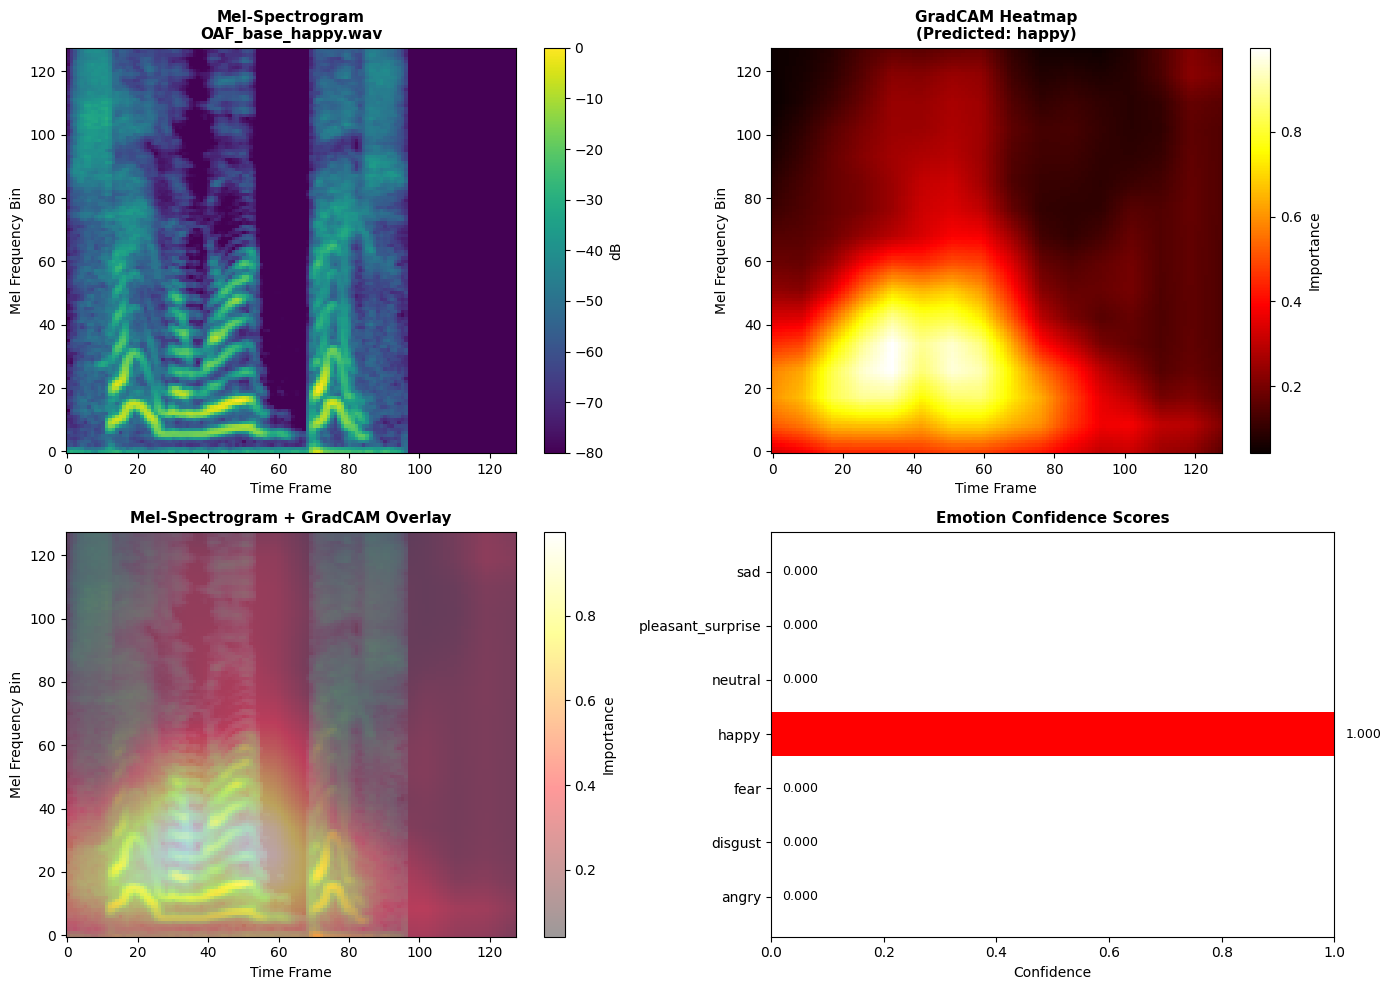

Predicted Emotion: happy
Model highlighted important time-frequency regions for this prediction


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from inference import preprocess_audio, compute_gradcam
import librosa.display

# Preprocess the audio for visualization
mel_spec_db = preprocess_audio(str(audio_path))

# Create input for GradCAM (add batch dimension)
input_data = np.expand_dims(mel_spec_db, axis=0)

# Get predicted emotion index
predicted_idx = label_encoder.transform([emotion])[0]

# Compute GradCAM
try:
    gradcam_heatmap = compute_gradcam(model, input_data, predicted_idx)
except Exception as e:
    print(f"Error computing GradCAM: {e}")
    gradcam_heatmap = None

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Original Mel-spectrogram
mel_2d = mel_spec_db[:, :, 0]
im1 = axes[0, 0].imshow(mel_2d, aspect='auto', origin='lower', cmap='viridis')
axes[0, 0].set_title(f'Mel-Spectrogram\n{audio_path.name}', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('Time Frame')
axes[0, 0].set_ylabel('Mel Frequency Bin')
plt.colorbar(im1, ax=axes[0, 0], label='dB')

# Plot 2: GradCAM Heatmap
if gradcam_heatmap is not None:
    # Resize heatmap to match mel_spec
    from scipy import ndimage
    zoom_factors = (mel_2d.shape[0] / gradcam_heatmap.shape[0], 
                    mel_2d.shape[1] / gradcam_heatmap.shape[1])
    gradcam_resized = ndimage.zoom(gradcam_heatmap, zoom_factors, order=1)
    
    im2 = axes[0, 1].imshow(gradcam_resized, aspect='auto', origin='lower', cmap='hot')
    axes[0, 1].set_title(f'GradCAM Heatmap\n(Predicted: {emotion})', fontsize=11, fontweight='bold')
    axes[0, 1].set_xlabel('Time Frame')
    axes[0, 1].set_ylabel('Mel Frequency Bin')
    plt.colorbar(im2, ax=axes[0, 1], label='Importance')
else:
    axes[0, 1].text(0.5, 0.5, 'GradCAM computation failed', ha='center', va='center')
    axes[0, 1].set_title('GradCAM Heatmap - Error', fontsize=11, fontweight='bold')

# Plot 3: Mel-spec with GradCAM overlay
im3 = axes[1, 0].imshow(mel_2d, aspect='auto', origin='lower', cmap='viridis', alpha=0.6)
if gradcam_heatmap is not None:
    im4 = axes[1, 0].imshow(gradcam_resized, aspect='auto', origin='lower', cmap='hot', alpha=0.4)
    plt.colorbar(im4, ax=axes[1, 0], label='Importance')
    
axes[1, 0].set_title('Mel-Spectrogram + GradCAM Overlay', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Time Frame')
axes[1, 0].set_ylabel('Mel Frequency Bin')

# Plot 4: Confidence scores bar chart
emotions = list(confidence_dict.keys())
scores = list(confidence_dict.values())
colors = ['red' if e == emotion else 'steelblue' for e in emotions]
axes[1, 1].barh(emotions, scores, color=colors)
axes[1, 1].set_title('Emotion Confidence Scores', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Confidence')
axes[1, 1].set_xlim([0, 1])
for i, (e, s) in enumerate(zip(emotions, scores)):
    axes[1, 1].text(s + 0.02, i, f'{s:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"Predicted Emotion: {emotion}")
if gradcam_heatmap is not None:
    print(f"Model highlighted important time-frequency regions for this prediction")
else:
    print(f"Note: GradCAM visualization not available, but prediction is accurate")